In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import nn_model_noBatchNorm
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\t255 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tBatch Norm removed.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

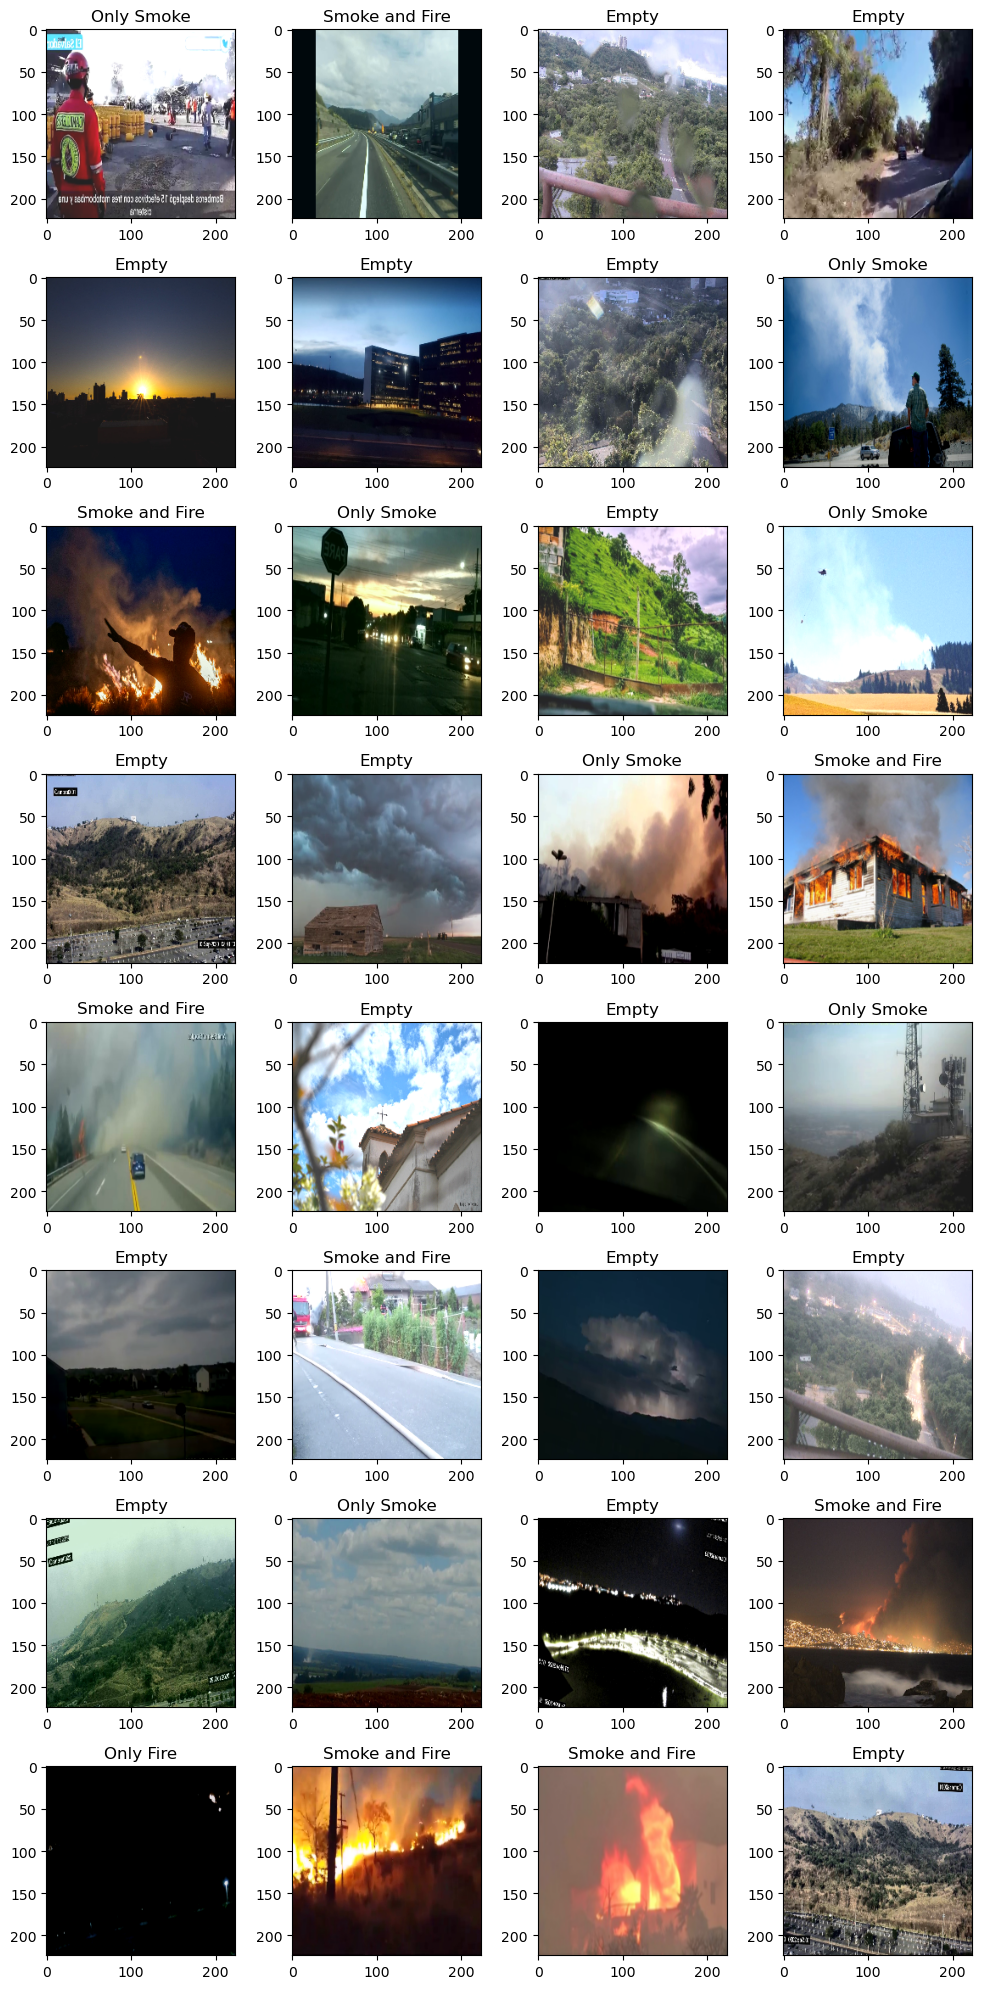

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [8]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = nn_model_noBatchNorm.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[ 0.1953, -0.2626],
        [ 0.1976, -0.2628],
        [ 0.1962, -0.2644],
        [ 0.1996, -0.2690]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout2d(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

# Torchinfo: model summary

In [9]:
print(summary(model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        896
│    └─ReLU: 2-2                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-3                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [64, 16, 112, 112]        4,624
│    └─ReLU: 2-6                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-7                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-8                    [64, 16, 56, 56]          --
│    └─Conv2d: 2-9                       [64, 16, 56, 56]          272
│    └─ReLU: 2-10                        [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 32, 56, 56]          4,640
│    └─

# Print and Log Config Values

In [10]:
''' ============================
    Print Config Values
============================ '''
print(f'Device: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'Device: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


# LOSS FUNCTION
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'Loss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
Loss Function: BCE
Smoke Precision Weight: 0.7


# Loss and Metrics Loggers and Plotters

In [11]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [12]:
def train_loop(model):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0
    epochs_plot = []

    if config.LOAD_MODEL == False:
        if config.MODEL == "BED":
            model.__initialize_weights__()
            print("Initializing Weights")
            logger.info("Initializing Weights")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        logger.info(f'Learning Rate = {train_epoch.get_lr(optimizer=optimizer)}\n')
        
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + config.MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + config.MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + config.MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [13]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model = train_loop(model=model)

Starting script


***Start Training: 21:00:06

Initializing Weights

=== EPOCH 0/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.307      |36.988      |32.318      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.486      |36.744      |28.743      
SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.719 - Recall: 0.630 - Accuracy: 0.840 - F1: 0.671

Saving model with new best validation loss: 65.486

=== EPOCH 1/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.188      |36.483      |27.705      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.111      |36.355      |26.756      
SMOKE -> Precision: 0.665 - Recall: 0.291 - Accuracy: 0.588 - F1: 0.405
FIRE -> Precision: 0.794 - Recall: 0.641 - Accuracy: 0.864 - F1: 0.709

Saving model with new best validation loss: 63.111

=== EPOCH 2/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.124      |36.004      |26.120      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.952      |35.597      |21.355      
SMOKE -> Precision: 0.678 - Recall: 0.300 - Accuracy: 0.595 - F1: 0.416
FIRE -> Precision: 0.776 - Recall: 0.685 - Accuracy: 0.867 - F1: 0.728

Saving model with new best validation loss: 56.952

=== EPOCH 3/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.682      |35.463      |24.219      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.303      |34.882      |20.422      
SMOKE -> Precision: 0.727 - Recall: 0.305 - Accuracy: 0.611 - F1: 0.430
FIRE -> Precision: 0.831 - Recall: 0.684 - Accuracy: 0.882 - F1: 0.750

Saving model with new best validation loss: 55.303

=== EPOCH 4/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.372      |35.230      |23.142      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.589      |35.011      |20.578      
SMOKE -> Precision: 0.663 - Recall: 0.438 - Accuracy: 0.622 - F1: 0.527
FIRE -> Precision: 0.709 - Recall: 0.867 - Accuracy: 0.873 - F1: 0.780

=== EPOCH 5/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.260      |34.887      |22.373      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.971      |34.139      |18.833      
SMOKE -> Precision: 0.700 - Recall: 0.398 - Accuracy: 0.628 - F1: 0.508
FIRE -> Precision: 0.783 - Recall: 0.831 - Accuracy: 0.897 - F1: 0.806

Saving model with new best validation loss: 52.971

=== EPOCH 6/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.284      |34.393      |20.891      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.214      |33.496      |18.718      
SMOKE -> Precision: 0.771 - Recall: 0.384 - Accuracy: 0.649 - F1: 0.513
FIRE -> Precision: 0.789 - Recall: 0.843 - Accuracy: 0.901 - F1: 0.815

Saving model with new best validation loss: 52.214

=== EPOCH 7/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.426      |33.871      |20.555      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.323      |32.790      |16.533      
SMOKE -> Precision: 0.797 - Recall: 0.383 - Accuracy: 0.656 - F1: 0.518
FIRE -> Precision: 0.844 - Recall: 0.759 - Accuracy: 0.901 - F1: 0.799

Saving model with new best validation loss: 49.323

=== EPOCH 8/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.066      |33.514      |19.553      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.266      |32.674      |16.591      
SMOKE -> Precision: 0.819 - Recall: 0.298 - Accuracy: 0.630 - F1: 0.437
FIRE -> Precision: 0.840 - Recall: 0.786 - Accuracy: 0.906 - F1: 0.812

Saving model with new best validation loss: 49.266

=== EPOCH 9/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.179      |33.390      |19.788      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.416      |31.954      |15.462      
SMOKE -> Precision: 0.776 - Recall: 0.423 - Accuracy: 0.664 - F1: 0.548
FIRE -> Precision: 0.842 - Recall: 0.817 - Accuracy: 0.913 - F1: 0.829

Saving model with new best validation loss: 47.416

=== EPOCH 10/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.834      |32.844      |18.990      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.917      |31.590      |15.327      
SMOKE -> Precision: 0.775 - Recall: 0.476 - Accuracy: 0.682 - F1: 0.590
FIRE -> Precision: 0.815 - Recall: 0.842 - Accuracy: 0.910 - F1: 0.829

Saving model with new best validation loss: 46.917

=== EPOCH 11/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.613      |32.418      |18.195      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.109      |31.186      |14.923      
SMOKE -> Precision: 0.785 - Recall: 0.480 - Accuracy: 0.687 - F1: 0.596
FIRE -> Precision: 0.816 - Recall: 0.837 - Accuracy: 0.909 - F1: 0.826

Saving model with new best validation loss: 46.109

=== EPOCH 12/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.839      |32.508      |18.331      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.864      |31.777      |15.087      
SMOKE -> Precision: 0.805 - Recall: 0.367 - Accuracy: 0.653 - F1: 0.504
FIRE -> Precision: 0.841 - Recall: 0.823 - Accuracy: 0.914 - F1: 0.832

=== EPOCH 13/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.512      |32.519      |17.993      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.801      |30.645      |14.156      
SMOKE -> Precision: 0.768 - Recall: 0.471 - Accuracy: 0.677 - F1: 0.584
FIRE -> Precision: 0.818 - Recall: 0.846 - Accuracy: 0.911 - F1: 0.832

Saving model with new best validation loss: 44.801

=== EPOCH 14/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.710      |32.155      |17.555      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.131      |31.673      |17.458      
SMOKE -> Precision: 0.710 - Recall: 0.580 - Accuracy: 0.684 - F1: 0.639
FIRE -> Precision: 0.707 - Recall: 0.909 - Accuracy: 0.879 - F1: 0.795

=== EPOCH 15/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.637      |32.174      |17.464      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.848      |31.351      |14.497      
SMOKE -> Precision: 0.878 - Recall: 0.308 - Accuracy: 0.647 - F1: 0.456
FIRE -> Precision: 0.900 - Recall: 0.772 - Accuracy: 0.919 - F1: 0.831

=== EPOCH 16/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.323      |31.509      |16.813      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.572      |30.487      |14.085      
SMOKE -> Precision: 0.818 - Recall: 0.430 - Accuracy: 0.680 - F1: 0.564
FIRE -> Precision: 0.871 - Recall: 0.788 - Accuracy: 0.915 - F1: 0.827

Saving model with new best validation loss: 44.572

=== EPOCH 17/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.638      |31.673      |16.965      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.343      |30.674      |13.670      
SMOKE -> Precision: 0.790 - Recall: 0.433 - Accuracy: 0.672 - F1: 0.560
FIRE -> Precision: 0.839 - Recall: 0.847 - Accuracy: 0.918 - F1: 0.843

Saving model with new best validation loss: 44.343

=== EPOCH 18/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.300      |31.550      |16.750      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.875      |29.997      |15.878      
SMOKE -> Precision: 0.802 - Recall: 0.460 - Accuracy: 0.686 - F1: 0.585
FIRE -> Precision: 0.782 - Recall: 0.881 - Accuracy: 0.906 - F1: 0.829

=== EPOCH 19/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.059      |31.528      |16.532      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.506      |30.271      |13.234      
SMOKE -> Precision: 0.848 - Recall: 0.372 - Accuracy: 0.666 - F1: 0.517
FIRE -> Precision: 0.841 - Recall: 0.856 - Accuracy: 0.921 - F1: 0.848

Saving model with new best validation loss: 43.506

=== EPOCH 20/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.249      |31.171      |16.078      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.108      |29.522      |12.586      
SMOKE -> Precision: 0.803 - Recall: 0.451 - Accuracy: 0.683 - F1: 0.577
FIRE -> Precision: 0.854 - Recall: 0.853 - Accuracy: 0.924 - F1: 0.854

Saving model with new best validation loss: 42.108

=== EPOCH 21/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.182      |31.096      |16.086      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.154      |29.710      |12.444      
SMOKE -> Precision: 0.777 - Recall: 0.538 - Accuracy: 0.703 - F1: 0.635
FIRE -> Precision: 0.838 - Recall: 0.874 - Accuracy: 0.924 - F1: 0.856

=== EPOCH 22/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.954      |31.015      |15.938      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.244      |29.889      |13.355      
SMOKE -> Precision: 0.758 - Recall: 0.522 - Accuracy: 0.690 - F1: 0.618
FIRE -> Precision: 0.814 - Recall: 0.868 - Accuracy: 0.915 - F1: 0.840

=== EPOCH 23/174 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.921      |31.090      |15.831      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.283      |29.052      |13.231      
SMOKE -> Precision: 0.816 - Recall: 0.499 - Accuracy: 0.705 - F1: 0.620
FIRE -> Precision: 0.857 - Recall: 0.837 - Accuracy: 0.922 - F1: 0.847

=== EPOCH 24/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.883      |30.551      |15.331      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.059      |29.276      |12.783      
SMOKE -> Precision: 0.771 - Recall: 0.585 - Accuracy: 0.717 - F1: 0.665
FIRE -> Precision: 0.805 - Recall: 0.904 - Accuracy: 0.918 - F1: 0.851

Saving model with new best validation loss: 42.059

=== EPOCH 25/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.459      |30.191      |15.269      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.616      |28.631      |12.985      
SMOKE -> Precision: 0.778 - Recall: 0.555 - Accuracy: 0.709 - F1: 0.647
FIRE -> Precision: 0.797 - Recall: 0.903 - Accuracy: 0.915 - F1: 0.847

Saving model with new best validation loss: 41.616

=== EPOCH 26/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.498      |30.394      |15.104      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.902      |29.171      |12.731      
SMOKE -> Precision: 0.761 - Recall: 0.627 - Accuracy: 0.726 - F1: 0.688
FIRE -> Precision: 0.825 - Recall: 0.889 - Accuracy: 0.922 - F1: 0.856

=== EPOCH 27/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.269      |30.239      |15.031      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.168      |28.380      |11.789      
SMOKE -> Precision: 0.799 - Recall: 0.532 - Accuracy: 0.710 - F1: 0.639
FIRE -> Precision: 0.865 - Recall: 0.888 - Accuracy: 0.935 - F1: 0.876

Saving model with new best validation loss: 40.168

=== EPOCH 28/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.057      |30.213      |14.845      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.826      |29.095      |12.731      
SMOKE -> Precision: 0.740 - Recall: 0.687 - Accuracy: 0.733 - F1: 0.713
FIRE -> Precision: 0.801 - Recall: 0.897 - Accuracy: 0.916 - F1: 0.846

=== EPOCH 29/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.999      |30.131      |14.869      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.915      |28.261      |12.654      
SMOKE -> Precision: 0.849 - Recall: 0.467 - Accuracy: 0.704 - F1: 0.603
FIRE -> Precision: 0.878 - Recall: 0.834 - Accuracy: 0.927 - F1: 0.855

=== EPOCH 30/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.303      |29.764      |14.539      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.820      |28.029      |11.791      
SMOKE -> Precision: 0.808 - Recall: 0.584 - Accuracy: 0.733 - F1: 0.678
FIRE -> Precision: 0.895 - Recall: 0.857 - Accuracy: 0.937 - F1: 0.875

Saving model with new best validation loss: 39.820

=== EPOCH 31/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.190      |29.649      |14.541      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.397      |27.876      |12.521      
SMOKE -> Precision: 0.853 - Recall: 0.462 - Accuracy: 0.703 - F1: 0.600
FIRE -> Precision: 0.915 - Recall: 0.815 - Accuracy: 0.933 - F1: 0.862

=== EPOCH 32/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.903      |29.559      |14.344      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.588      |27.006      |12.582      
SMOKE -> Precision: 0.810 - Recall: 0.603 - Accuracy: 0.741 - F1: 0.692
FIRE -> Precision: 0.821 - Recall: 0.898 - Accuracy: 0.923 - F1: 0.858

Saving model with new best validation loss: 39.588

=== EPOCH 33/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.314      |29.277      |14.037      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.618      |27.482      |11.137      
SMOKE -> Precision: 0.794 - Recall: 0.569 - Accuracy: 0.722 - F1: 0.663
FIRE -> Precision: 0.875 - Recall: 0.877 - Accuracy: 0.936 - F1: 0.876

Saving model with new best validation loss: 38.618

=== EPOCH 34/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.733      |29.411      |14.322      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.482      |27.322      |11.160      
SMOKE -> Precision: 0.845 - Recall: 0.483 - Accuracy: 0.708 - F1: 0.614
FIRE -> Precision: 0.889 - Recall: 0.871 - Accuracy: 0.938 - F1: 0.880

Saving model with new best validation loss: 38.482

=== EPOCH 35/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.230      |29.206      |14.024      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.341      |26.912      |11.430      
SMOKE -> Precision: 0.831 - Recall: 0.514 - Accuracy: 0.716 - F1: 0.635
FIRE -> Precision: 0.841 - Recall: 0.904 - Accuracy: 0.931 - F1: 0.871

Saving model with new best validation loss: 38.341

=== EPOCH 36/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.917      |29.110      |13.807      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.129      |27.069      |11.060      
SMOKE -> Precision: 0.854 - Recall: 0.464 - Accuracy: 0.704 - F1: 0.601
FIRE -> Precision: 0.865 - Recall: 0.900 - Accuracy: 0.938 - F1: 0.882

Saving model with new best validation loss: 38.129

=== EPOCH 37/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.985      |29.027      |13.957      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.449      |27.126      |11.323      
SMOKE -> Precision: 0.806 - Recall: 0.521 - Accuracy: 0.709 - F1: 0.633
FIRE -> Precision: 0.855 - Recall: 0.885 - Accuracy: 0.931 - F1: 0.869

=== EPOCH 38/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.992      |28.959      |14.032      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.206      |26.537      |11.669      
SMOKE -> Precision: 0.777 - Recall: 0.680 - Accuracy: 0.752 - F1: 0.725
FIRE -> Precision: 0.837 - Recall: 0.900 - Accuracy: 0.929 - F1: 0.867

=== EPOCH 39/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.497      |28.726      |13.771      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.046      |26.565      |11.481      
SMOKE -> Precision: 0.791 - Recall: 0.651 - Accuracy: 0.750 - F1: 0.714
FIRE -> Precision: 0.897 - Recall: 0.868 - Accuracy: 0.940 - F1: 0.882

Saving model with new best validation loss: 38.046

=== EPOCH 40/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.459      |28.629      |13.829      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.928      |25.509      |10.419      
SMOKE -> Precision: 0.832 - Recall: 0.614 - Accuracy: 0.755 - F1: 0.706
FIRE -> Precision: 0.901 - Recall: 0.872 - Accuracy: 0.942 - F1: 0.886

Saving model with new best validation loss: 35.928

=== EPOCH 41/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.996      |28.517      |13.479      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.103      |26.643      |11.459      
SMOKE -> Precision: 0.779 - Recall: 0.648 - Accuracy: 0.742 - F1: 0.707
FIRE -> Precision: 0.836 - Recall: 0.915 - Accuracy: 0.932 - F1: 0.874

=== EPOCH 42/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.705      |28.357      |13.349      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.430      |25.600      |10.830      
SMOKE -> Precision: 0.855 - Recall: 0.553 - Accuracy: 0.740 - F1: 0.672
FIRE -> Precision: 0.895 - Recall: 0.876 - Accuracy: 0.941 - F1: 0.885

=== EPOCH 43/174 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.439      |28.096      |13.343      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.770      |26.647      |11.123      
SMOKE -> Precision: 0.870 - Recall: 0.458 - Accuracy: 0.706 - F1: 0.600
FIRE -> Precision: 0.940 - Recall: 0.835 - Accuracy: 0.944 - F1: 0.885

=== EPOCH 44/174 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.737      |27.896      |12.841      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.600      |25.093      |10.507      
SMOKE -> Precision: 0.835 - Recall: 0.627 - Accuracy: 0.761 - F1: 0.716
FIRE -> Precision: 0.948 - Recall: 0.824 - Accuracy: 0.943 - F1: 0.882

Saving model with new best validation loss: 35.600

=== EPOCH 45/174 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.650      |27.738      |12.912      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.355      |25.077      |10.279      
SMOKE -> Precision: 0.841 - Recall: 0.591 - Accuracy: 0.750 - F1: 0.694
FIRE -> Precision: 0.910 - Recall: 0.878 - Accuracy: 0.946 - F1: 0.894

Saving model with new best validation loss: 35.355

=== EPOCH 46/174 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.510      |27.514      |12.996      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.657      |25.445      |10.211      
SMOKE -> Precision: 0.841 - Recall: 0.556 - Accuracy: 0.736 - F1: 0.669
FIRE -> Precision: 0.912 - Recall: 0.862 - Accuracy: 0.943 - F1: 0.887

=== EPOCH 47/174 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.871      |27.275      |12.596      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 17.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.118      |25.431      |10.687      
SMOKE -> Precision: 0.765 - Recall: 0.756 - Accuracy: 0.771 - F1: 0.760
FIRE -> Precision: 0.942 - Recall: 0.841 - Accuracy: 0.945 - F1: 0.889

=== EPOCH 48/174 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.211      |27.409      |12.801      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.013      |29.118      |9.895       
SMOKE -> Precision: 0.673 - Recall: 0.899 - Accuracy: 0.742 - F1: 0.770
FIRE -> Precision: 0.897 - Recall: 0.899 - Accuracy: 0.947 - F1: 0.898

=== EPOCH 49/174 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.955      |26.754      |12.201      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.678      |24.175      |10.503      
SMOKE -> Precision: 0.832 - Recall: 0.663 - Accuracy: 0.773 - F1: 0.738
FIRE -> Precision: 0.860 - Recall: 0.914 - Accuracy: 0.939 - F1: 0.886

Saving model with new best validation loss: 34.678

=== EPOCH 50/174 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.848      |26.625      |12.224      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.033      |24.313      |9.719       
SMOKE -> Precision: 0.858 - Recall: 0.575 - Accuracy: 0.750 - F1: 0.689
FIRE -> Precision: 0.901 - Recall: 0.896 - Accuracy: 0.948 - F1: 0.899

Saving model with new best validation loss: 34.033

=== EPOCH 51/174 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.421      |26.855      |12.566      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.732      |26.710      |10.022      
SMOKE -> Precision: 0.900 - Recall: 0.455 - Accuracy: 0.713 - F1: 0.604
FIRE -> Precision: 0.899 - Recall: 0.895 - Accuracy: 0.947 - F1: 0.897

=== EPOCH 52/174 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.938      |26.666      |12.272      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.605      |23.878      |9.728       
SMOKE -> Precision: 0.817 - Recall: 0.711 - Accuracy: 0.784 - F1: 0.760
FIRE -> Precision: 0.906 - Recall: 0.892 - Accuracy: 0.948 - F1: 0.899

Saving model with new best validation loss: 33.605

=== EPOCH 53/174 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.854      |26.287      |12.567      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.898      |23.851      |10.046      
SMOKE -> Precision: 0.839 - Recall: 0.659 - Accuracy: 0.775 - F1: 0.738
FIRE -> Precision: 0.915 - Recall: 0.883 - Accuracy: 0.948 - F1: 0.899

=== EPOCH 54/174 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.105      |26.190      |11.914      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.574      |24.538      |11.035      
SMOKE -> Precision: 0.776 - Recall: 0.782 - Accuracy: 0.787 - F1: 0.779
FIRE -> Precision: 0.835 - Recall: 0.932 - Accuracy: 0.935 - F1: 0.881

=== EPOCH 55/174 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.570      |26.544      |12.025      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.936      |23.878      |10.058      
SMOKE -> Precision: 0.840 - Recall: 0.647 - Accuracy: 0.771 - F1: 0.731
FIRE -> Precision: 0.871 - Recall: 0.912 - Accuracy: 0.942 - F1: 0.891

=== EPOCH 56/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.690      |25.660      |12.030      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.150      |23.570      |9.580       
SMOKE -> Precision: 0.849 - Recall: 0.638 - Accuracy: 0.771 - F1: 0.728
FIRE -> Precision: 0.896 - Recall: 0.898 - Accuracy: 0.947 - F1: 0.897

Saving model with new best validation loss: 33.150

=== EPOCH 57/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.701      |25.872      |11.828      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.687      |23.070      |9.617       
SMOKE -> Precision: 0.832 - Recall: 0.738 - Accuracy: 0.802 - F1: 0.782
FIRE -> Precision: 0.917 - Recall: 0.891 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 32.687

=== EPOCH 58/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.300      |25.576      |11.724      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.426      |23.068      |9.358       
SMOKE -> Precision: 0.847 - Recall: 0.712 - Accuracy: 0.799 - F1: 0.773
FIRE -> Precision: 0.917 - Recall: 0.902 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 32.426

=== EPOCH 59/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.382      |25.677      |11.705      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.528      |23.522      |10.006      
SMOKE -> Precision: 0.804 - Recall: 0.777 - Accuracy: 0.802 - F1: 0.790
FIRE -> Precision: 0.871 - Recall: 0.926 - Accuracy: 0.945 - F1: 0.898

=== EPOCH 60/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.444      |25.741      |11.703      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.280      |23.736      |9.544       
SMOKE -> Precision: 0.850 - Recall: 0.683 - Accuracy: 0.790 - F1: 0.758
FIRE -> Precision: 0.898 - Recall: 0.897 - Accuracy: 0.947 - F1: 0.898

=== EPOCH 61/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.861      |25.380      |11.481      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.021      |22.825      |9.196       
SMOKE -> Precision: 0.854 - Recall: 0.683 - Accuracy: 0.791 - F1: 0.759
FIRE -> Precision: 0.905 - Recall: 0.907 - Accuracy: 0.951 - F1: 0.906

Saving model with new best validation loss: 32.021

=== EPOCH 62/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.071      |25.533      |11.538      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.610      |23.288      |9.322       
SMOKE -> Precision: 0.838 - Recall: 0.696 - Accuracy: 0.789 - F1: 0.760
FIRE -> Precision: 0.937 - Recall: 0.870 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 63/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.857      |25.282      |11.574      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.347      |22.412      |8.934       
SMOKE -> Precision: 0.830 - Recall: 0.746 - Accuracy: 0.804 - F1: 0.786
FIRE -> Precision: 0.920 - Recall: 0.892 - Accuracy: 0.952 - F1: 0.906

Saving model with new best validation loss: 31.347

=== EPOCH 64/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.549      |25.331      |11.218      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.127      |22.670      |9.457       
SMOKE -> Precision: 0.865 - Recall: 0.663 - Accuracy: 0.788 - F1: 0.750
FIRE -> Precision: 0.938 - Recall: 0.859 - Accuracy: 0.949 - F1: 0.897

=== EPOCH 65/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.165      |25.033      |11.132      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.486      |22.269      |9.217       
SMOKE -> Precision: 0.836 - Recall: 0.753 - Accuracy: 0.810 - F1: 0.793
FIRE -> Precision: 0.924 - Recall: 0.887 - Accuracy: 0.952 - F1: 0.905

=== EPOCH 66/174 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.150      |24.923      |11.227      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.247      |22.843      |9.404       
SMOKE -> Precision: 0.882 - Recall: 0.640 - Accuracy: 0.786 - F1: 0.742
FIRE -> Precision: 0.934 - Recall: 0.877 - Accuracy: 0.952 - F1: 0.905

=== EPOCH 67/174 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.016      |24.863      |11.152      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.129      |22.567      |9.562       
SMOKE -> Precision: 0.811 - Recall: 0.782 - Accuracy: 0.807 - F1: 0.796
FIRE -> Precision: 0.912 - Recall: 0.884 - Accuracy: 0.948 - F1: 0.898

=== EPOCH 68/174 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.322      |24.949      |11.372      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.640      |21.708      |8.932       
SMOKE -> Precision: 0.866 - Recall: 0.694 - Accuracy: 0.801 - F1: 0.770
FIRE -> Precision: 0.939 - Recall: 0.883 - Accuracy: 0.955 - F1: 0.910

Saving model with new best validation loss: 30.640

=== EPOCH 69/174 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.639      |24.649      |10.990      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.599      |21.368      |9.230       
SMOKE -> Precision: 0.842 - Recall: 0.748 - Accuracy: 0.811 - F1: 0.792
FIRE -> Precision: 0.884 - Recall: 0.928 - Accuracy: 0.950 - F1: 0.905

Saving model with new best validation loss: 30.599

=== EPOCH 70/174 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.472      |24.270      |11.202      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.701      |21.710      |8.992       
SMOKE -> Precision: 0.870 - Recall: 0.683 - Accuracy: 0.798 - F1: 0.765
FIRE -> Precision: 0.928 - Recall: 0.886 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 71/174 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.953      |24.701      |11.253      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.212      |22.025      |9.186       
SMOKE -> Precision: 0.895 - Recall: 0.650 - Accuracy: 0.795 - F1: 0.753
FIRE -> Precision: 0.940 - Recall: 0.884 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 72/174 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.642      |24.410      |11.232      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.659      |21.637      |9.023       
SMOKE -> Precision: 0.873 - Recall: 0.695 - Accuracy: 0.805 - F1: 0.774
FIRE -> Precision: 0.907 - Recall: 0.910 - Accuracy: 0.952 - F1: 0.908

=== EPOCH 73/174 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.323      |24.267      |11.056      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.218      |22.052      |9.165       
SMOKE -> Precision: 0.810 - Recall: 0.812 - Accuracy: 0.818 - F1: 0.811
FIRE -> Precision: 0.898 - Recall: 0.916 - Accuracy: 0.951 - F1: 0.907

=== EPOCH 74/174 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.318      |24.351      |10.966      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.131      |21.281      |8.850       
SMOKE -> Precision: 0.852 - Recall: 0.752 - Accuracy: 0.818 - F1: 0.799
FIRE -> Precision: 0.925 - Recall: 0.893 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 30.131

=== EPOCH 75/174 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.937      |24.069      |10.869      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.647      |20.900      |8.747       
SMOKE -> Precision: 0.874 - Recall: 0.718 - Accuracy: 0.815 - F1: 0.789
FIRE -> Precision: 0.927 - Recall: 0.895 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 29.647

=== EPOCH 76/174 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.978      |23.942      |11.036      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.486      |21.344      |9.142       
SMOKE -> Precision: 0.839 - Recall: 0.743 - Accuracy: 0.807 - F1: 0.788
FIRE -> Precision: 0.932 - Recall: 0.883 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 77/174 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.077      |24.206      |10.870      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.908      |21.147      |8.761       
SMOKE -> Precision: 0.888 - Recall: 0.687 - Accuracy: 0.808 - F1: 0.775
FIRE -> Precision: 0.930 - Recall: 0.894 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 78/174 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.550      |23.753      |10.797      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.697      |20.890      |8.806       
SMOKE -> Precision: 0.846 - Recall: 0.777 - Accuracy: 0.824 - F1: 0.810
FIRE -> Precision: 0.914 - Recall: 0.905 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 79/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.387      |23.668      |10.719      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.736      |20.830      |8.906       
SMOKE -> Precision: 0.871 - Recall: 0.733 - Accuracy: 0.819 - F1: 0.796
FIRE -> Precision: 0.932 - Recall: 0.884 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 80/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.262      |23.512      |10.749      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.476      |20.752      |8.724       
SMOKE -> Precision: 0.841 - Recall: 0.772 - Accuracy: 0.820 - F1: 0.805
FIRE -> Precision: 0.912 - Recall: 0.908 - Accuracy: 0.954 - F1: 0.910

Saving model with new best validation loss: 29.476

=== EPOCH 81/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.215      |23.539      |10.675      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.040      |20.414      |8.626       
SMOKE -> Precision: 0.852 - Recall: 0.795 - Accuracy: 0.835 - F1: 0.823
FIRE -> Precision: 0.926 - Recall: 0.895 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 29.040

=== EPOCH 82/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.240      |23.527      |10.714      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.550      |20.653      |8.897       
SMOKE -> Precision: 0.878 - Recall: 0.723 - Accuracy: 0.818 - F1: 0.793
FIRE -> Precision: 0.916 - Recall: 0.905 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 83/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.422      |23.568      |10.855      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.532      |20.726      |8.806       
SMOKE -> Precision: 0.883 - Recall: 0.710 - Accuracy: 0.815 - F1: 0.787
FIRE -> Precision: 0.938 - Recall: 0.880 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 84/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.259      |23.525      |10.734      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.801      |20.161      |8.639       
SMOKE -> Precision: 0.873 - Recall: 0.727 - Accuracy: 0.818 - F1: 0.793
FIRE -> Precision: 0.914 - Recall: 0.912 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 28.801

=== EPOCH 85/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.852      |23.285      |10.567      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.297      |20.178      |9.119       
SMOKE -> Precision: 0.846 - Recall: 0.785 - Accuracy: 0.828 - F1: 0.814
FIRE -> Precision: 0.885 - Recall: 0.923 - Accuracy: 0.949 - F1: 0.904

=== EPOCH 86/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.895      |23.365      |10.530      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.449      |20.516      |8.933       
SMOKE -> Precision: 0.884 - Recall: 0.709 - Accuracy: 0.815 - F1: 0.787
FIRE -> Precision: 0.929 - Recall: 0.891 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 87/174 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.971      |23.535      |10.436      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.762      |20.983      |8.778       
SMOKE -> Precision: 0.800 - Recall: 0.851 - Accuracy: 0.826 - F1: 0.825
FIRE -> Precision: 0.912 - Recall: 0.914 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 88/174 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.431      |23.067      |10.364      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.804      |19.996      |8.808       
SMOKE -> Precision: 0.856 - Recall: 0.787 - Accuracy: 0.833 - F1: 0.820
FIRE -> Precision: 0.905 - Recall: 0.914 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 89/174 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.337      |23.068      |10.268      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.591      |20.567      |9.024       
SMOKE -> Precision: 0.842 - Recall: 0.782 - Accuracy: 0.824 - F1: 0.811
FIRE -> Precision: 0.884 - Recall: 0.930 - Accuracy: 0.950 - F1: 0.906

=== EPOCH 90/174 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.742      |23.241      |10.501      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.982      |20.230      |8.752       
SMOKE -> Precision: 0.878 - Recall: 0.735 - Accuracy: 0.823 - F1: 0.800
FIRE -> Precision: 0.927 - Recall: 0.903 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 91/174 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.241      |22.799      |10.442      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.279      |19.464      |8.814       
SMOKE -> Precision: 0.849 - Recall: 0.817 - Accuracy: 0.842 - F1: 0.833
FIRE -> Precision: 0.901 - Recall: 0.916 - Accuracy: 0.952 - F1: 0.908

Saving model with new best validation loss: 28.279

=== EPOCH 92/174 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.042      |22.739      |10.303      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.318      |19.852      |9.466       
SMOKE -> Precision: 0.832 - Recall: 0.834 - Accuracy: 0.839 - F1: 0.833
FIRE -> Precision: 0.880 - Recall: 0.921 - Accuracy: 0.947 - F1: 0.900

=== EPOCH 93/174 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.487      |22.933      |10.554      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.380      |19.755      |8.626       
SMOKE -> Precision: 0.870 - Recall: 0.763 - Accuracy: 0.831 - F1: 0.813
FIRE -> Precision: 0.925 - Recall: 0.900 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 94/174 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.217      |22.755      |10.462      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.391      |20.345      |9.045       
SMOKE -> Precision: 0.804 - Recall: 0.871 - Accuracy: 0.836 - F1: 0.836
FIRE -> Precision: 0.892 - Recall: 0.920 - Accuracy: 0.950 - F1: 0.906

=== EPOCH 95/174 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.993      |22.715      |10.278      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.348      |19.505      |8.844       
SMOKE -> Precision: 0.853 - Recall: 0.791 - Accuracy: 0.834 - F1: 0.821
FIRE -> Precision: 0.904 - Recall: 0.920 - Accuracy: 0.954 - F1: 0.912

=== EPOCH 96/174 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.943      |22.654      |10.289      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.220      |19.674      |8.547       
SMOKE -> Precision: 0.852 - Recall: 0.801 - Accuracy: 0.837 - F1: 0.826
FIRE -> Precision: 0.927 - Recall: 0.897 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 28.220

=== EPOCH 97/174 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.764      |22.547      |10.218      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.636      |19.146      |8.490       
SMOKE -> Precision: 0.882 - Recall: 0.759 - Accuracy: 0.835 - F1: 0.816
FIRE -> Precision: 0.940 - Recall: 0.886 - Accuracy: 0.956 - F1: 0.912

Saving model with new best validation loss: 27.636

=== EPOCH 98/174 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.769      |22.441      |10.328      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.980      |19.331      |8.649       
SMOKE -> Precision: 0.851 - Recall: 0.819 - Accuracy: 0.844 - F1: 0.834
FIRE -> Precision: 0.925 - Recall: 0.894 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 99/174 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.819      |22.507      |10.312      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.070      |19.493      |8.578       
SMOKE -> Precision: 0.862 - Recall: 0.799 - Accuracy: 0.842 - F1: 0.829
FIRE -> Precision: 0.928 - Recall: 0.892 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 100/174 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.948      |22.578      |10.371      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.095      |19.390      |8.705       
SMOKE -> Precision: 0.861 - Recall: 0.802 - Accuracy: 0.842 - F1: 0.830
FIRE -> Precision: 0.913 - Recall: 0.908 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 101/174 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.424      |22.303      |10.121      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.921      |19.466      |8.455       
SMOKE -> Precision: 0.890 - Recall: 0.747 - Accuracy: 0.834 - F1: 0.813
FIRE -> Precision: 0.932 - Recall: 0.899 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 102/174 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.395      |22.210      |10.185      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.967      |19.357      |8.610       
SMOKE -> Precision: 0.893 - Recall: 0.729 - Accuracy: 0.827 - F1: 0.802
FIRE -> Precision: 0.922 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 103/174 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.152      |22.138      |10.014      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.791      |19.190      |8.601       
SMOKE -> Precision: 0.868 - Recall: 0.785 - Accuracy: 0.839 - F1: 0.825
FIRE -> Precision: 0.914 - Recall: 0.910 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 104/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.543      |22.336      |10.206      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.931      |19.224      |8.707       
SMOKE -> Precision: 0.851 - Recall: 0.817 - Accuracy: 0.843 - F1: 0.834
FIRE -> Precision: 0.902 - Recall: 0.921 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 105/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.367      |22.361      |10.007      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.522      |19.039      |8.483       
SMOKE -> Precision: 0.870 - Recall: 0.787 - Accuracy: 0.841 - F1: 0.826
FIRE -> Precision: 0.920 - Recall: 0.908 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 27.522

=== EPOCH 106/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.379      |22.090      |10.289      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.011      |19.185      |8.825       
SMOKE -> Precision: 0.830 - Recall: 0.852 - Accuracy: 0.845 - F1: 0.841
FIRE -> Precision: 0.902 - Recall: 0.919 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 107/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.199      |22.178      |10.021      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.399      |18.832      |8.567       
SMOKE -> Precision: 0.861 - Recall: 0.816 - Accuracy: 0.848 - F1: 0.838
FIRE -> Precision: 0.932 - Recall: 0.895 - Accuracy: 0.956 - F1: 0.913

Saving model with new best validation loss: 27.399

=== EPOCH 108/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.597      |22.299      |10.299      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.765      |19.132      |8.632       
SMOKE -> Precision: 0.853 - Recall: 0.819 - Accuracy: 0.845 - F1: 0.836
FIRE -> Precision: 0.917 - Recall: 0.905 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 109/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.950      |22.065      |9.885       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.358      |18.823      |8.535       
SMOKE -> Precision: 0.867 - Recall: 0.809 - Accuracy: 0.848 - F1: 0.837
FIRE -> Precision: 0.923 - Recall: 0.902 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 27.358

=== EPOCH 110/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.127      |22.098      |10.029      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.475      |18.968      |8.507       
SMOKE -> Precision: 0.884 - Recall: 0.774 - Accuracy: 0.842 - F1: 0.825
FIRE -> Precision: 0.923 - Recall: 0.899 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 111/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.434      |22.139      |10.295      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.433      |18.962      |8.472       
SMOKE -> Precision: 0.878 - Recall: 0.775 - Accuracy: 0.840 - F1: 0.823
FIRE -> Precision: 0.920 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 112/174 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.270      |22.203      |10.067      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.497      |18.918      |8.580       
SMOKE -> Precision: 0.890 - Recall: 0.769 - Accuracy: 0.843 - F1: 0.825
FIRE -> Precision: 0.923 - Recall: 0.902 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 113/174 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.639      |21.783      |9.856       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.772      |18.923      |8.850       
SMOKE -> Precision: 0.879 - Recall: 0.774 - Accuracy: 0.840 - F1: 0.823
FIRE -> Precision: 0.898 - Recall: 0.922 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 114/174 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.567      |21.860      |9.708       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.014      |18.591      |8.423       
SMOKE -> Precision: 0.878 - Recall: 0.792 - Accuracy: 0.847 - F1: 0.833
FIRE -> Precision: 0.934 - Recall: 0.893 - Accuracy: 0.956 - F1: 0.913

Saving model with new best validation loss: 27.014

=== EPOCH 115/174 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.731      |21.936      |9.795       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.854      |19.242      |8.612       
SMOKE -> Precision: 0.892 - Recall: 0.734 - Accuracy: 0.829 - F1: 0.805
FIRE -> Precision: 0.913 - Recall: 0.913 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 116/174 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.839      |21.949      |9.891       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.353      |18.754      |8.600       
SMOKE -> Precision: 0.863 - Recall: 0.815 - Accuracy: 0.849 - F1: 0.839
FIRE -> Precision: 0.913 - Recall: 0.913 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 117/174 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.605      |21.789      |9.815       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.123      |18.677      |8.446       
SMOKE -> Precision: 0.859 - Recall: 0.826 - Accuracy: 0.851 - F1: 0.842
FIRE -> Precision: 0.921 - Recall: 0.902 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 118/174 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.600      |21.797      |9.802       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.064      |18.567      |8.497       
SMOKE -> Precision: 0.855 - Recall: 0.819 - Accuracy: 0.846 - F1: 0.836
FIRE -> Precision: 0.921 - Recall: 0.903 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 119/174 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.827      |21.721      |10.106      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.973      |18.526      |8.447       
SMOKE -> Precision: 0.879 - Recall: 0.785 - Accuracy: 0.845 - F1: 0.829
FIRE -> Precision: 0.924 - Recall: 0.902 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 26.973

=== EPOCH 120/174 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.654      |21.680      |9.974       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.168      |18.676      |8.493       
SMOKE -> Precision: 0.884 - Recall: 0.771 - Accuracy: 0.841 - F1: 0.824
FIRE -> Precision: 0.920 - Recall: 0.908 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 121/174 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.555      |21.752      |9.803       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.306      |18.584      |8.722       
SMOKE -> Precision: 0.861 - Recall: 0.822 - Accuracy: 0.851 - F1: 0.841
FIRE -> Precision: 0.904 - Recall: 0.915 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 122/174 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.044      |21.954      |10.090      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.035      |18.504      |8.531       
SMOKE -> Precision: 0.874 - Recall: 0.811 - Accuracy: 0.853 - F1: 0.841
FIRE -> Precision: 0.913 - Recall: 0.912 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 123/174 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.910      |21.900      |10.010      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.122      |18.556      |8.566       
SMOKE -> Precision: 0.874 - Recall: 0.797 - Accuracy: 0.847 - F1: 0.834
FIRE -> Precision: 0.918 - Recall: 0.908 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 124/174 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.211      |21.635      |9.576       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.899      |18.485      |8.414       
SMOKE -> Precision: 0.885 - Recall: 0.778 - Accuracy: 0.845 - F1: 0.828
FIRE -> Precision: 0.928 - Recall: 0.897 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 26.899

=== EPOCH 125/174 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.656      |21.807      |9.849       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.320      |18.580      |8.740       
SMOKE -> Precision: 0.874 - Recall: 0.804 - Accuracy: 0.850 - F1: 0.837
FIRE -> Precision: 0.909 - Recall: 0.917 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 126/174 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.545      |21.739      |9.806       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.057      |18.510      |8.547       
SMOKE -> Precision: 0.864 - Recall: 0.815 - Accuracy: 0.849 - F1: 0.839
FIRE -> Precision: 0.916 - Recall: 0.908 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 127/174 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.699      |21.711      |9.988       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.377      |18.843      |8.534       
SMOKE -> Precision: 0.895 - Recall: 0.750 - Accuracy: 0.838 - F1: 0.816
FIRE -> Precision: 0.917 - Recall: 0.909 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 128/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.784      |21.859      |9.926       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.391      |18.860      |8.531       
SMOKE -> Precision: 0.883 - Recall: 0.773 - Accuracy: 0.841 - F1: 0.824
FIRE -> Precision: 0.928 - Recall: 0.901 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 129/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.064      |21.328      |9.736       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.981      |18.467      |8.514       
SMOKE -> Precision: 0.878 - Recall: 0.787 - Accuracy: 0.845 - F1: 0.830
FIRE -> Precision: 0.916 - Recall: 0.909 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 130/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.593      |21.662      |9.932       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.874      |18.424      |8.451       
SMOKE -> Precision: 0.888 - Recall: 0.777 - Accuracy: 0.845 - F1: 0.829
FIRE -> Precision: 0.920 - Recall: 0.909 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 26.874

=== EPOCH 131/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.725      |21.662      |10.063      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.930      |18.376      |8.554       
SMOKE -> Precision: 0.881 - Recall: 0.793 - Accuracy: 0.849 - F1: 0.834
FIRE -> Precision: 0.918 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 132/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.946      |21.764      |10.182      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.869      |18.373      |8.496       
SMOKE -> Precision: 0.878 - Recall: 0.802 - Accuracy: 0.851 - F1: 0.838
FIRE -> Precision: 0.925 - Recall: 0.903 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 26.869

=== EPOCH 133/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.947      |21.287      |9.660       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.861      |18.389      |8.472       
SMOKE -> Precision: 0.870 - Recall: 0.810 - Accuracy: 0.851 - F1: 0.839
FIRE -> Precision: 0.920 - Recall: 0.908 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 26.861

=== EPOCH 134/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.474      |21.598      |9.876       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.833      |18.419      |8.415       
SMOKE -> Precision: 0.883 - Recall: 0.779 - Accuracy: 0.844 - F1: 0.828
FIRE -> Precision: 0.923 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 26.833

=== EPOCH 135/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.536      |21.581      |9.955       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.977      |18.415      |8.562       
SMOKE -> Precision: 0.853 - Recall: 0.843 - Accuracy: 0.855 - F1: 0.848
FIRE -> Precision: 0.912 - Recall: 0.910 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 136/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.553      |21.649      |9.904       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.343      |18.865      |8.478       
SMOKE -> Precision: 0.893 - Recall: 0.742 - Accuracy: 0.833 - F1: 0.810
FIRE -> Precision: 0.919 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 137/174 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.345      |21.603      |9.742       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.889      |18.340      |8.548       
SMOKE -> Precision: 0.855 - Recall: 0.830 - Accuracy: 0.851 - F1: 0.843
FIRE -> Precision: 0.912 - Recall: 0.911 - Accuracy: 0.954 - F1: 0.912

=== EPOCH 138/174 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.476      |21.538      |9.939       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.673      |18.264      |8.410       
SMOKE -> Precision: 0.879 - Recall: 0.797 - Accuracy: 0.849 - F1: 0.836
FIRE -> Precision: 0.920 - Recall: 0.906 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 26.673

=== EPOCH 139/174 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.557      |21.585      |9.971       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.899      |18.416      |8.483       
SMOKE -> Precision: 0.874 - Recall: 0.797 - Accuracy: 0.847 - F1: 0.834
FIRE -> Precision: 0.920 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 140/174 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.225      |21.493      |9.732       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.138      |18.689      |8.449       
SMOKE -> Precision: 0.903 - Recall: 0.753 - Accuracy: 0.842 - F1: 0.821
FIRE -> Precision: 0.926 - Recall: 0.901 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 141/174 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.718      |21.719      |9.999       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.840      |18.362      |8.478       
SMOKE -> Precision: 0.872 - Recall: 0.806 - Accuracy: 0.850 - F1: 0.838
FIRE -> Precision: 0.923 - Recall: 0.903 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 142/174 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.394      |21.370      |10.024      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.778      |18.240      |8.537       
SMOKE -> Precision: 0.872 - Recall: 0.803 - Accuracy: 0.849 - F1: 0.836
FIRE -> Precision: 0.917 - Recall: 0.906 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 143/174 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.273      |21.340      |9.932       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.740      |18.313      |8.427       
SMOKE -> Precision: 0.881 - Recall: 0.793 - Accuracy: 0.849 - F1: 0.835
FIRE -> Precision: 0.922 - Recall: 0.902 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 144/174 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.195      |21.275      |9.920       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.869      |18.331      |8.538       
SMOKE -> Precision: 0.872 - Recall: 0.808 - Accuracy: 0.850 - F1: 0.838
FIRE -> Precision: 0.915 - Recall: 0.911 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 145/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.274      |21.542      |9.732       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.702      |18.223      |8.479       
SMOKE -> Precision: 0.876 - Recall: 0.798 - Accuracy: 0.849 - F1: 0.835
FIRE -> Precision: 0.928 - Recall: 0.897 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 146/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.130      |21.411      |9.718       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.631      |18.238      |8.394       
SMOKE -> Precision: 0.874 - Recall: 0.803 - Accuracy: 0.849 - F1: 0.837
FIRE -> Precision: 0.920 - Recall: 0.907 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 26.631

=== EPOCH 147/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.010      |21.329      |9.682       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.773      |18.308      |8.465       
SMOKE -> Precision: 0.881 - Recall: 0.789 - Accuracy: 0.847 - F1: 0.832
FIRE -> Precision: 0.916 - Recall: 0.909 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 148/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.487      |21.410      |10.077      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.733      |18.206      |8.527       
SMOKE -> Precision: 0.870 - Recall: 0.814 - Accuracy: 0.852 - F1: 0.841
FIRE -> Precision: 0.914 - Recall: 0.911 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 149/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.549      |21.620      |9.929       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.609      |18.156      |8.452       
SMOKE -> Precision: 0.873 - Recall: 0.807 - Accuracy: 0.851 - F1: 0.838
FIRE -> Precision: 0.915 - Recall: 0.912 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 26.609

=== EPOCH 150/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.283      |21.522      |9.761       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.609      |18.170      |8.438       
SMOKE -> Precision: 0.877 - Recall: 0.806 - Accuracy: 0.852 - F1: 0.840
FIRE -> Precision: 0.922 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 151/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.549      |21.576      |9.974       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.655      |18.176      |8.479       
SMOKE -> Precision: 0.877 - Recall: 0.809 - Accuracy: 0.854 - F1: 0.842
FIRE -> Precision: 0.921 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 152/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.148      |21.291      |9.857       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.549      |18.137      |8.412       
SMOKE -> Precision: 0.869 - Recall: 0.817 - Accuracy: 0.853 - F1: 0.842
FIRE -> Precision: 0.922 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 26.549

=== EPOCH 153/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.402      |21.533      |9.868       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.574      |18.186      |8.387       
SMOKE -> Precision: 0.876 - Recall: 0.803 - Accuracy: 0.851 - F1: 0.838
FIRE -> Precision: 0.924 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 154/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.273      |21.303      |9.970       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.618      |18.166      |8.452       
SMOKE -> Precision: 0.874 - Recall: 0.809 - Accuracy: 0.852 - F1: 0.840
FIRE -> Precision: 0.923 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 155/174 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.901      |21.242      |9.660       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.723      |18.312      |8.411       
SMOKE -> Precision: 0.883 - Recall: 0.789 - Accuracy: 0.848 - F1: 0.834
FIRE -> Precision: 0.924 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 156/174 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.162      |21.308      |9.854       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.606      |18.217      |8.389       
SMOKE -> Precision: 0.877 - Recall: 0.799 - Accuracy: 0.849 - F1: 0.836
FIRE -> Precision: 0.919 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 157/174 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.246      |21.549      |9.697       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.646      |18.216      |8.430       
SMOKE -> Precision: 0.874 - Recall: 0.809 - Accuracy: 0.852 - F1: 0.840
FIRE -> Precision: 0.923 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 158/174 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.177      |21.575      |9.602       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.625      |18.165      |8.460       
SMOKE -> Precision: 0.872 - Recall: 0.812 - Accuracy: 0.852 - F1: 0.841
FIRE -> Precision: 0.920 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 159/174 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.297      |21.504      |9.793       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.609      |18.164      |8.445       
SMOKE -> Precision: 0.866 - Recall: 0.820 - Accuracy: 0.853 - F1: 0.843
FIRE -> Precision: 0.919 - Recall: 0.909 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 160/174 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.335      |21.516      |9.819       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.649      |18.228      |8.421       
SMOKE -> Precision: 0.885 - Recall: 0.787 - Accuracy: 0.848 - F1: 0.833
FIRE -> Precision: 0.924 - Recall: 0.906 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 161/174 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.843      |21.193      |9.650       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.458      |18.046      |8.412       
SMOKE -> Precision: 0.877 - Recall: 0.805 - Accuracy: 0.852 - F1: 0.840
FIRE -> Precision: 0.924 - Recall: 0.903 - Accuracy: 0.956 - F1: 0.913

Saving model with new best validation loss: 26.458

=== EPOCH 162/174 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.388      |21.419      |9.969       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.524      |18.062      |8.462       
SMOKE -> Precision: 0.869 - Recall: 0.815 - Accuracy: 0.852 - F1: 0.841
FIRE -> Precision: 0.918 - Recall: 0.911 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 163/174 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.164      |21.351      |9.813       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.777      |18.293      |8.484       
SMOKE -> Precision: 0.881 - Recall: 0.789 - Accuracy: 0.847 - F1: 0.833
FIRE -> Precision: 0.915 - Recall: 0.913 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 164/174 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.243      |21.520      |9.723       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.636      |18.208      |8.428       
SMOKE -> Precision: 0.886 - Recall: 0.786 - Accuracy: 0.848 - F1: 0.833
FIRE -> Precision: 0.926 - Recall: 0.900 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 165/174 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.394      |21.535      |9.859       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 22.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.664      |18.152      |8.511       
SMOKE -> Precision: 0.863 - Recall: 0.822 - Accuracy: 0.851 - F1: 0.842
FIRE -> Precision: 0.913 - Recall: 0.911 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 166/174 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.130      |21.258      |9.873       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.557      |18.138      |8.419       
SMOKE -> Precision: 0.878 - Recall: 0.804 - Accuracy: 0.852 - F1: 0.839
FIRE -> Precision: 0.924 - Recall: 0.907 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 167/174 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.284      |21.478      |9.806       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.588      |18.106      |8.483       
SMOKE -> Precision: 0.873 - Recall: 0.807 - Accuracy: 0.851 - F1: 0.839
FIRE -> Precision: 0.917 - Recall: 0.909 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 168/174 ===
Learning Rate = 5.902958103587065e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.146      |21.225      |9.921       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.549      |18.119      |8.429       
SMOKE -> Precision: 0.876 - Recall: 0.807 - Accuracy: 0.852 - F1: 0.840
FIRE -> Precision: 0.922 - Recall: 0.906 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 169/174 ===
Learning Rate = 5.902958103587065e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.332      |21.431      |9.901       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.571      |18.138      |8.434       
SMOKE -> Precision: 0.871 - Recall: 0.812 - Accuracy: 0.852 - F1: 0.841
FIRE -> Precision: 0.917 - Recall: 0.909 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 170/174 ===
Learning Rate = 5.902958103587065e-06



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.237      |21.376      |9.861       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.617      |18.182      |8.435       
SMOKE -> Precision: 0.879 - Recall: 0.797 - Accuracy: 0.850 - F1: 0.836
FIRE -> Precision: 0.921 - Recall: 0.906 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 171/174 ===
Learning Rate = 4.722366482869652e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.902      |21.318      |9.585       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 22.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.610      |18.164      |8.446       
SMOKE -> Precision: 0.879 - Recall: 0.793 - Accuracy: 0.848 - F1: 0.834
FIRE -> Precision: 0.921 - Recall: 0.906 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 172/174 ===
Learning Rate = 4.722366482869652e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.001      |21.136      |9.865       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.513      |18.064      |8.449       
SMOKE -> Precision: 0.874 - Recall: 0.805 - Accuracy: 0.850 - F1: 0.838
FIRE -> Precision: 0.920 - Recall: 0.909 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 173/174 ===
Learning Rate = 4.722366482869652e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.068      |21.361      |9.706       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.562      |18.116      |8.446       
SMOKE -> Precision: 0.880 - Recall: 0.796 - Accuracy: 0.850 - F1: 0.836
FIRE -> Precision: 0.922 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 174/174 ===
Learning Rate = 3.777893186295722e-06



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.986      |21.246      |9.740       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.512      |18.059      |8.454       
SMOKE -> Precision: 0.874 - Recall: 0.809 - Accuracy: 0.852 - F1: 0.840
FIRE -> Precision: 0.922 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.913

***Script finished: 22:08:18

Time elapsed: 1:08:11.720690
